In [3]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from rrmpg.models import GR4J

In [4]:
data_location = os.path.join('/data')

In [5]:
# Calibration period
calib_start_year = 1990
calib_end_year = 2000

# Holdout period
holdout_start_year = 2000
holdout_end_year = 2005

In [6]:
# Load the data
maulescreek_rain_et = pd.read_csv(
    os.path.join(
        data_location,
        'SILO(-30.5,150.1)',
        'FAO56_Penman_Monteith_1989.csv'
    )
)
maulescreek_streamflow = pd.read_csv(
    os.path.join(
        data_location,
        'water_level',
        'bom_gauge_daily_mean_419051.csv'
    )
)

# fix dates 
maulescreek_rain_et['Date'] = pd.to_datetime(maulescreek_rain_et['Date2'],format="%d-%m-%Y")
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Timestamp'],utc=True, format='%Y-%m-%d')
maulescreek_streamflow['Date'] = maulescreek_streamflow['Date'].dt.date
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Date'])

In [7]:
# 
merged_data = pd.merge(
    maulescreek_rain_et,
    maulescreek_streamflow,
    left_on='Date',
    right_on='Date'
)

# Slicing the data into calibration and holdout
calibration_data = merged_data.loc[((merged_data['Date']).dt.year >= calib_start_year) & ((merged_data['Date']).dt.year < calib_end_year)].reset_index(drop=True)

holdout_data = merged_data.loc[((merged_data['Date']).dt.year >= holdout_start_year) & ((merged_data['Date']).dt.year < holdout_end_year)].reset_index(drop=True)

In [8]:
calibration_data.head()

,Date,Day,Date2,T.Max,Smx,T.Min,Smn,Rain,Srn,Evap,...,Ssl,VP,Svp,RHmaxT,RHminT,FAO56,Timestamp,Value,Quality Code,Interpolation Type
0,1990-01-01,1,1-01-1990,37.8,25,20.0,25,0.0,25,11.1,...,25,18.3,25,27.9,78.3,7.6,1990-01-02T00:00:00.000+10:00,0.147,140,603
1,1990-01-02,2,2-01-1990,40.2,25,21.4,25,0.6,25,11.4,...,25,18.0,25,24.1,70.7,8.3,1990-01-03T00:00:00.000+10:00,0.144,140,603
2,1990-01-03,3,3-01-1990,39.5,25,20.5,25,0.0,25,14.3,...,25,14.8,25,20.6,61.4,8.5,1990-01-04T00:00:00.000+10:00,0.141,140,603
3,1990-01-04,4,4-01-1990,42.2,25,22.3,25,0.0,25,13.6,...,25,14.0,25,16.9,52.0,9.1,1990-01-05T00:00:00.000+10:00,0.137,140,603
4,1990-01-05,5,5-01-1990,37.6,25,20.0,25,0.0,25,11.9,...,25,18.2,25,28.1,77.9,7.8,1990-01-06T00:00:00.000+10:00,0.135,140,603


In [9]:
holdout_data.head()

,Date,Day,Date2,T.Max,Smx,T.Min,Smn,Rain,Srn,Evap,...,Ssl,VP,Svp,RHmaxT,RHminT,FAO56,Timestamp,Value,Quality Code,Interpolation Type
0,2000-01-01,1,1-01-2000,30.1,25,14.2,25,0.0,25,8.5,...,25,12.5,25,29.3,77.2,6.6,2000-01-02T00:00:00.000+10:00,0.086,140,603
1,2000-01-02,2,2-01-2000,31.2,25,14.3,25,0.4,25,8.6,...,25,13.0,25,28.6,79.8,6.6,2000-01-03T00:00:00.000+10:00,0.086,140,603
2,2000-01-03,3,3-01-2000,32.7,25,15.2,25,0.0,25,8.4,...,25,15.4,25,31.1,89.2,6.8,2000-01-04T00:00:00.000+10:00,0.077,140,603
3,2000-01-04,4,4-01-2000,30.8,25,19.0,25,0.0,25,7.9,...,25,18.2,25,41.0,82.9,5.3,2000-01-05T00:00:00.000+10:00,0.077,140,603
4,2000-01-05,5,5-01-2000,29.6,25,17.0,25,0.4,25,9.6,...,25,12.0,25,28.9,62.0,6.7,2000-01-06T00:00:00.000+10:00,0.073,140,603


In [10]:
model = GR4J()
model.get_params()

{'x1': 606.4539271724095,
 'x2': 2.173096182907617,
 'x3': 195.65578030600943,
 'x4': 2.4038569097771623}

In [11]:
# Tune GR4J parameters
prcp_calib = calibration_data.loc[:, 'Rain'].values
et_calib = calibration_data.loc[:, 'FAO56'].values
flow_calib = calibration_data.loc[:, 'Value'].values
date_calib = calibration_data.loc[:, 'Date'].values


result = model.fit(flow_calib, prcp_calib, et_calib)

In [12]:
params = {}

param_names = model.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model.set_params(params)

# To be sure, let's look at the current model parameters
model.get_params()

{'x1': 109.37118080390698, 'x2': 2.141438271698809, 'x3': 20.0, 'x4': 1.1}

In [13]:
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

def nnse(nse):
    return 1/(2 - nse)

def evaluate(model, dates, et, prcp, flow):
    
    flow_pred = model.simulate(prcp, et)

    nnse_score = nnse(nse(flow, flow_pred))
    print(f"Normalised NSE: {nnse_score}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(dates, flow, label='obs')
    ax.plot(dates, flow_pred, label='pred')

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()
    

Normalised NSE: 0.00026058827147875345


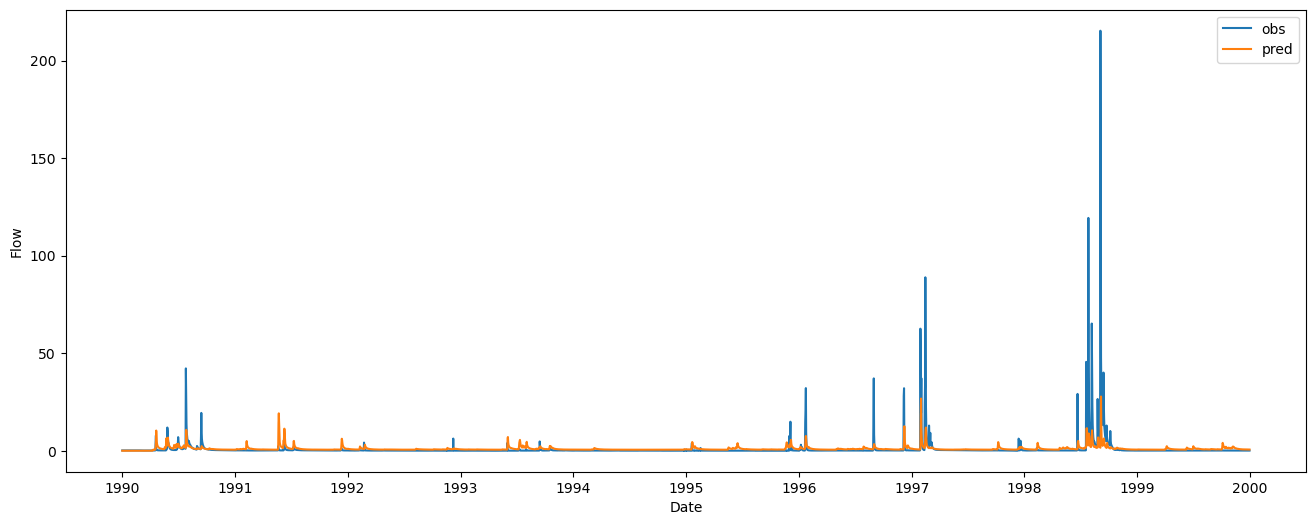

In [14]:
evaluate(model, date_calib,  et_calib, prcp_calib, flow_calib)


Normalised NSE: 0.0005145962776340199


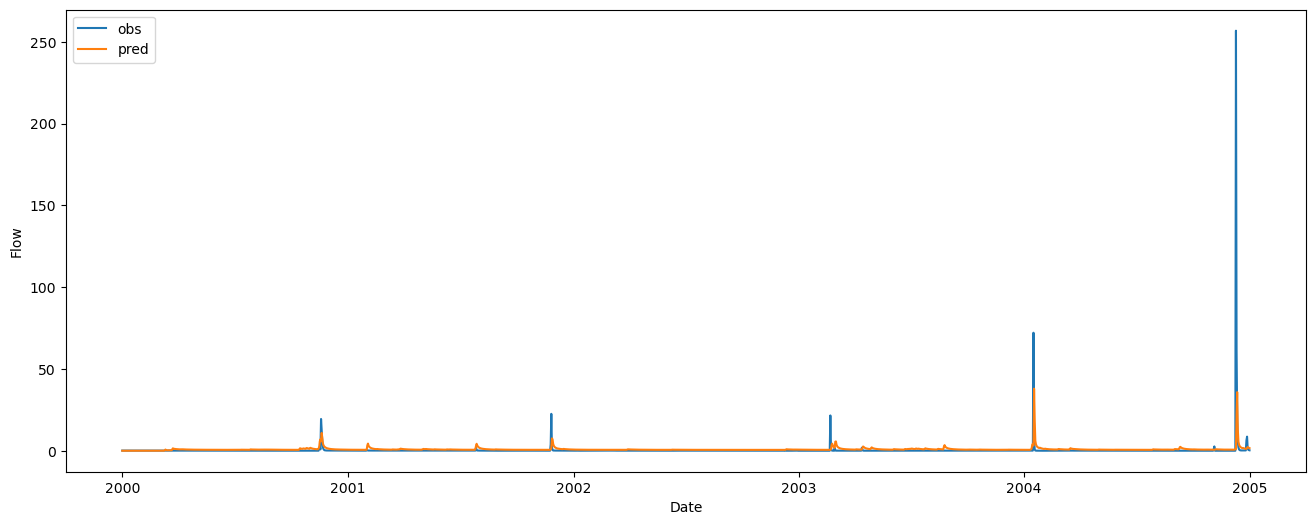

In [15]:
# Evaluate on unseen data
prcp_holdout = holdout_data.loc[:, 'Rain'].values
et_holdout= holdout_data.loc[:, 'FAO56'].values
flow_holdout = holdout_data.loc[:, 'Value'].values
date_holdout = holdout_data.loc[:, 'Date'].values

evaluate(model, date_holdout,  et_holdout, prcp_holdout, flow_holdout)
